[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevin7261/Geographic-Data-Science-with-Python/blob/main/Choropleth_Mapping.ipynb)

# Choropleth Mapping

https://geographicdata.science/book/notebooks/05_choropleth.html


In [577]:
# @title 初始值設定

PROJECT_NAME = "14_15_23_台南市區_合併位置_2" #"14_15_23_台南市區_合併位置_1"
GEOJSON_NAME = "台南市區"

DENGUE_DAILY_GSHEET_PATH = "https://docs.google.com/spreadsheets/d/1vYyoq0Vf07kuWJU0Rg375jpHT9r9WzA2jiCPl3V3Oi4/edit?gid=2026372005#gid=2026372005"
GEOJSON_FILE_PATH = "https://drive.google.com/file/d/19HAcRgd1o3KYugAIgcnM3xKN6ybUQ2RX/view?usp=sharing" #"https://drive.google.com/file/d/1SImPP3lj5ksvlcTQnEddtbpbZnIh1Jv8/view?usp=sharing"
WORKSHEET_NAME = PROJECT_NAME

In [578]:
# @title 下載台北思源黑體

# 下載台北思源黑體，並隱藏輸出
!wget -q -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 匯入必要的庫
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 新增字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')

# 設定字體
mpl.rc('font', family='Taipei Sans TC Beta')


In [579]:
# @title 安裝套件

!pip install -q geopandas gdown pysal

---

# Principles

In [580]:
# @title 匯入函式庫

import seaborn
import pandas
import geopandas
import pysal
import numpy
import matplotlib.pyplot as plt

## 資料集

1. 2015年台南市登革熱病例 (xlsx)
1. 台南市最小統計區 (shp)

In [581]:
# @title 載入台南市登革熱病例(gsheet)

# ✅ 匯入套件
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe

SPREADSHEET_ID_GSHEET = DENGUE_DAILY_GSHEET_PATH.split("/d/")[1].split("/")[0]

# ✅ 認證授權
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# ✅ 開啟工作表
sh = gc.open_by_key(SPREADSHEET_ID_GSHEET)
worksheet = sh.worksheet(WORKSHEET_NAME)

# ✅ 將工作表轉為 DataFrame
ref = get_as_dataframe(worksheet)  # 可加入 index_col="name" 如欄位存在

ref.set_index("name", inplace=True)

# ✅ 預覽資料
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, A0902-09 to A6735-54
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   count_14  431 non-null    float64
 1   count_15  431 non-null    float64
 2   count_23  431 non-null    float64
dtypes: float64(3)
memory usage: 13.5+ KB


In [582]:
# @title 下載geojson

import gdown

# ✅ 從 Google Drive 分享連結中提取檔案 ID
file_id = GEOJSON_FILE_PATH.split("/d/")[1].split("/")[0]

# ✅ 建立 direct download 連結
download_url = f"https://drive.google.com/uc?id={file_id}"

# ✅ 執行下載（保留原始檔名）
gdown.download(download_url, quiet=False)  # 不指定 output，就會用原檔名

# ✅ 驗證是否下載成功
import os
downloaded_files = os.listdir()
print("📂 當前目錄檔案：", downloaded_files)

Downloading...
From: https://drive.google.com/uc?id=19HAcRgd1o3KYugAIgcnM3xKN6ybUQ2RX
To: /content/台南市區_2.geojson
100%|██████████| 1.35M/1.35M [00:00<00:00, 108MB/s]

📂 當前目錄檔案： ['.config', '台南市區.geojson', 'TaipeiSansTCBeta-Regular.ttf', '15_台南市區_合併位置.geojson', '台南市區_1.geojson', '台南市區_2.geojson', '臺北市_村里_綜稅綜合所得總額.gpkg', 'sample_data']


In [583]:
# @title 載入台南市最小統計區(geojson)

lads = geopandas.read_file(
    f"{GEOJSON_NAME}.geojson",
)#.set_index("CODE2")

lads["name"] = lads["CODE2"]

lads.set_index("CODE2")

lads.info()

#print(lads.crs) # EPSG:4979 Geodetic 3D coordinate system

lads.set_crs(epsg=3826, inplace=True, allow_override=True) # EPSG:3826 TWD97

print(lads.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5146 entries, 0 to 5145
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   U_ID       5146 non-null   int32   
 1   CODEBASE   5146 non-null   object  
 2   CODE1      5146 non-null   object  
 3   CODE2      5146 non-null   object  
 4   TOWN_ID    5146 non-null   object  
 5   TOWN       5146 non-null   object  
 6   COUNTY_ID  5146 non-null   object  
 7   COUNTY     5146 non-null   object  
 8   X          5146 non-null   float64 
 9   Y          5146 non-null   float64 
 10  AREA       5146 non-null   float64 
 11  geometry   5146 non-null   geometry
 12  name       5146 non-null   object  
dtypes: float64(3), geometry(1), int32(1), object(8)
memory usage: 502.7+ KB
EPSG:3826


# 分析count欄位

In [584]:
# @title 用index欄位合併csv與shp

mx = (
    geopandas.GeoDataFrame(
        # ✅ 保留原有 X/Y 欄位並合併計數資料
        lads[["name", "X", "Y", "geometry"]].join(ref[["count_14", "count_15", "count_23"]], how="left"),
        crs=lads.crs
    )
    .to_crs(epsg=3857)[  # ✅ 投影轉換為 Web Mercator
        ["name", "X", "Y", "count_14", "count_15", "count_23", "geometry"]
    ]
    .fillna({  # ✅ 空值補 0
        "count_14": 0,
        "count_15": 0,
        "count_23": 0
    })
)

# ✅ 將 count 欄位轉為 int
for col in ["count_14", "count_15", "count_23"]:
    mx[col] = mx[col].astype(int)

# ✅ 預覽結果
mx.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5146 entries, 0 to 5145
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      5146 non-null   object  
 1   X         5146 non-null   float64 
 2   Y         5146 non-null   float64 
 3   count_14  5146 non-null   int64   
 4   count_15  5146 non-null   int64   
 5   count_23  5146 non-null   int64   
 6   geometry  5146 non-null   geometry
dtypes: float64(2), geometry(1), int64(3), object(1)
memory usage: 321.6+ KB


# Quantitative data classification

In [585]:
mx[["count_14", "count_15", "count_23"]].head()
mx

,name,X,Y,count_14,count_15,count_23,geometry
0,A6733-43,166172.65021,2.535587e+06,0,0,0,"POLYGON Z ((13378845.862 2622386.622 0, 133788..."
1,A6733-44,165903.12757,2.535458e+06,0,0,0,"POLYGON Z ((13378463.253 2622325.614 0, 133784..."
2,A6733-43,166223.37937,2.535525e+06,0,0,0,"POLYGON Z ((13378842.709 2622316.43 0, 1337884..."
3,A6732-60,171126.85822,2.540743e+06,0,0,0,"POLYGON Z ((13383965.22 2628003.339 0, 1338402..."
4,A6733-28,166383.60272,2.540732e+06,0,0,0,"POLYGON Z ((13378799.238 2627974.02 0, 1337879..."
...,...,...,...,...,...,...,...
5141,A6735-38,166362.82568,2.549376e+06,0,0,0,"POLYGON Z ((13378820.429 2637452.736 0, 133788..."
5142,A6735-26,167482.77750,2.549442e+06,0,0,0,"POLYGON Z ((13379983.232 2637454.734 0, 133800..."
5143,A6735-30,166716.06082,2.549388e+06,0,0,0,"POLYGON Z ((13379288.313 2637433.868 0, 133792..."
5144,A6735-31,170398.24631,2.549387e+06,0,0,0,"POLYGON Z ((13383125.584 2637445.293 0, 133832..."


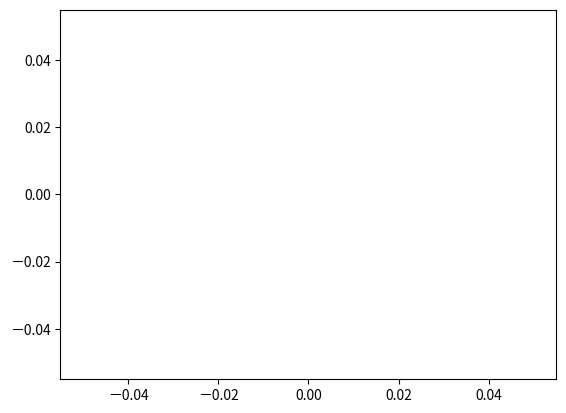

In [586]:
# Plot histogram
filtered = mx[mx["count_15"] > 0]

ax = seaborn.histplot(filtered["count_15"], bins=10)
# Add rug on horizontal axis
seaborn.rugplot(filtered["count_15"], height=0.05, color="red", ax=ax);

In [587]:
mx["count_15"].describe()

,count_15
count,5146.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [588]:
counts, bins, patches = ax.hist(mx["count_15"], bins=5)

In [589]:
counts # 數量

array([   0.,    0., 5146.,    0.,    0.])

In [590]:
bins # 斷點

array([-0.5, -0.3, -0.1,  0.1,  0.3,  0.5])

In [591]:
import mapclassify

## Equal intervals

In [592]:
ei5 = mapclassify.EqualInterval(mx["count_15"], k=5)
ei5

ValueError: Not enough unique values in array to form 5 classes. All values in `y` are equal.

## Quantiles 分位數

In [ ]:
q5 = mapclassify.Quantiles(mx.count_15, k=5)
q5

In [ ]:
q5.bins[1:] - q5.bins[:-1]

In [ ]:
# 隨機產生資料

# Set seed for reproducibility
numpy.random.seed(12345)
# Generate a variable of 20 values randomly
# selected from 0 to 10
x = numpy.random.randint(0, 10, 20)
# Manually ensure the first ten values are 0 (the
# minimum value)
x[0:10] = x.min()
x

In [ ]:
ties = mapclassify.Quantiles(x, k=5)
ties

In [ ]:
ux = numpy.unique(x)
ux

## Mean-standard deviation 平均標準差

In [ ]:
msd = mapclassify.StdMean(mx["count_15"])
msd

## Maximum breaks

In [ ]:
mb5 = mapclassify.MaximumBreaks(mx["count_15"], k=5)
mb5

## Boxplot

In [ ]:
bp = mapclassify.BoxPlot(mx["count_15"])
bp

In [ ]:
bp1 = mapclassify.BoxPlot(mx["count_15"], hinge=1)
bp1

## Head-tail breaks

In [ ]:
ht = mapclassify.HeadTailBreaks(mx["count_15"])
ht

## Jenks-Caspall breaks

In [ ]:
numpy.random.seed(12345)
jc5 = mapclassify.JenksCaspall(mx["count_15"], k=5)
jc5

## Fisher-Jenks breaks

In [ ]:

numpy.random.seed(12345)
fj5 = mapclassify.FisherJenks(mx["count_15"], k=5)
fj5

## Max-p

In [ ]:
# mp5 = mapclassify.MaxP(mx["count_15"], k=5)
# mp5

## Comparing classification schemes

In [ ]:
# 計算ADCM (absolute deviation around class medians)，越低越好

# Bunch classifier objects
class5 = q5, ei5, ht, mb5, msd, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = numpy.array([c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pandas.DataFrame(fits)
# Add classifier names
adcms["classifier"] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ["ADCM", "Classifier"]
ax = seaborn.barplot(
    y="Classifier", x="ADCM", data=adcms, palette="Pastel1"
)

In [ ]:
# Append class values as a separate column
mx["Quantiles"] = q5.yb
mx["Equal Interval"] = ei5.yb
mx["Head-Tail Breaks"] = ht.yb
mx["Maximum Breaks"] = mb5.yb
mx["Mean-Standard Deviation"] = msd.yb
mx["Fisher-Jenks"] = fj5.yb
mx["Jenks Caspall"] = jc5.yb
mx["MaxP"] = mp5.yb

In [ ]:
#f, ax = plt.subplots(1, figsize=(9, 3))
f, ax = plt.subplots(1, figsize=(90, 3))
seaborn.heatmap(
    mx.set_index("name")
    .sort_values("count_15")[
        [
            "Head-Tail Breaks",
            "Fisher-Jenks",
            "Maximum Breaks",
            "Equal Interval",
            "MaxP",
            "Quantiles",
            "Jenks Caspall",
            "Mean-Standard Deviation",
        ]
    ]
    .T,
    cmap="YlGn",
    cbar=False,
    ax=ax,
)
ax.set_xlabel("State ID");

In [ ]:
# ✅ 建立修正後的 class5，確保每個 c.counts 長度為 5（多的截斷、少的補 NaN）
class5_fixed = []

for c in class5:
    counts = list(c.counts)
    # 若群數少於 5 → 補 NaN
    while len(counts) < 5:
        counts.append(float("nan"))
    # 若群數多於 5 → 截斷
    counts = counts[:5]

    # 模擬一個物件，具有 c.name 和截斷後 counts 屬性
    class Fixed:
        pass

    fixed = Fixed()
    fixed.name = c.name
    fixed.counts = counts
    class5_fixed.append(fixed)

# ✅ 完全照你要求的寫法建立表格
pandas.DataFrame(
    {c.name: c.counts for c in class5_fixed},
    index=["Class-{}".format(i) for i in range(5)],
)

In [ ]:
# pandas.DataFrame(
#     {c.name: c.counts for c in class5},
#     index=["Class-{}".format(i) for i in range(5)],
# )

# Color

In [ ]:
ax = mx.plot(
    column="count_15",  # Data to plot
    scheme="Quantiles",  # Classification scheme
    cmap="YlGn",  # Color palette
    legend=True,  # Add legend
    legend_kwds={"fmt": "{:.0f}"},  # Remove decimals in legend
)
ax.set_axis_off();

## Sequential palettes

In [ ]:
ax = mx.plot(
    column="count_15",  # Data to plot
    scheme="Quantiles",  # Classification scheme
    cmap="Blues",  # Color palette
    edgecolor="k",  # Borderline color
    linewidth=0.1,  # Borderline width
    legend=True,  # Add legend
    legend_kwds={
        "fmt": "{:.0f}"
    },  # Remove decimals in legend (for legibility)
)
ax.set_axis_off();

## Diverging palettes

In [ ]:
# Create income-based rank table (Rank 1 is highest)
rnk = mx[["count_14", "count_15", "count_23"]].rank(ascending=False)
# Compute change from count_15 to count_14
rnk["change"] = rnk["count_15"] - rnk["count_14"]
# Add column with bin class
rnk["class"] = pandas.cut(rnk["change"], [-numpy.inf, -5, 0, 5, numpy.inf])

In [ ]:
ax = (
    mx[["geometry"]]
    .join(rnk)
    .plot("class", legend=True, cmap="RdYlGn")
)
ax.set_axis_off();

## Qualitative palettes

In [ ]:
mx["JenksCaspall"] = jc5.yb # 儲存count_15分類

In [ ]:
mx["JenksCaspall"].head()

In [ ]:
ax = mx.plot("JenksCaspall")
ax.set_axis_off();

In [ ]:
ax = mx.plot("JenksCaspall", categorical=True, legend=True)
ax.set_axis_off();

# Advanced topics

## User-defined choropleths

In [ ]:
classi = mapclassify.UserDefined(
    #mx["count_14"], [10000, 12500, 15000]
    mx["count_23"], [0, 100, 200]
)
classi

In [ ]:
classi.plot(
    mx,  # Use geometries in the geo-table
    legend=True,  # Add a legend
    legend_kwds={
        "loc": "upper right"
    },  # Place legend on top right corner
    axis_on=False,  # Remove axis
    cmap="viridis_r",  # Use reverse Viridis
);

In [ ]:
# Classify values specifying bins
lbls = pandas.cut(
    #mx["count_14"], [-numpy.inf, 10000, 12500, 15000, numpy.inf]
    mx["count_23"], [-numpy.inf, 50, 100, 150, numpy.inf]
)
# Dynamically assign to geo-table and plot with a legend
ax = mx.plot(lbls, cmap="viridis_r", legend=True)
# Remove axis
ax.set_axis_off();

## Pooled classifications

In [ ]:
# List the years we want of pc GDP
years = ["count_14", "count_15", "count_23"]
# Create pooled classification
pooled = mapclassify.Pooled(mx[years], classifier="Quantiles", k=5)

In [ ]:
# Set up figure with four axis
f, axs = plt.subplots(2, 2, figsize=(12, 12))
# Flatten the array of axis so you can loop over
# in one dimension
axs = axs.flatten()
# Loop over each year
for i, y in enumerate(years):
    mx.plot(
        y,  # Year to plot
        scheme="UserDefined",  # Use our own bins
        classification_kwds={
            "bins": pooled.global_classifier.bins
        },  # Use global bins
        legend=True,  # Add a legend
        ax=axs[i],  # Plot on the corresponding axis
    )
    # Remove axis
    axs[i].set_axis_off()
    # Name the subplot with the name of the column
    axs[i].set_title(y)
# Tight layout to better use space
plt.tight_layout()
# Display figure
plt.show()